In [1]:
import os
from keras.layers import Layer, Input, GlobalAveragePooling2D, Lambda, Dense
from keras.layers import ConvLSTM2D, Conv2D, AveragePooling2D, BatchNormalization
from keras.constraints import unit_norm, non_neg
from keras.activations import softmax
from keras.models import Model
from keras.initializers import Constant
from keras.constraints import Constraint
from keras import backend as K
from keras.layers.convolutional import _Conv
from keras.legacy import interfaces
from keras.engine import InputSpec
import tensorflow as tf
import numpy as np 

Using TensorFlow backend.
C:\Users\goeld\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\goeld\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\goeld\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
class Conv2DSymPadding( _Conv ) :
    @interfaces.legacy_conv2d_support
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 padding='same',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(Conv2DSymPadding, self).__init__(
            rank=2,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.input_spec = InputSpec(ndim=4)
    def get_config(self):
        config = super(Conv2DSymPadding, self).get_config()
        config.pop('rank')
        return config
    def call( self, inputs ) :
        if ( isinstance( self.kernel_size, tuple ) ) :
            kh, kw = self.kernel_size
        else :
            kh = kw = self.kernel_size
        ph, pw = kh//2, kw//2
        inputs_pad = tf.pad( inputs, [[0,0],[ph,ph],[pw,pw],[0,0]], mode='symmetric' )
        outputs = K.conv2d(
                inputs_pad,
                self.kernel,
                strides=self.strides,
                padding='valid',
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [3]:
class BayarConstraint( Constraint ) :
    def __init__( self ) :
        self.mask = None
    def _initialize_mask( self, w ) :
        nb_rows, nb_cols, nb_inputs, nb_outputs = K.int_shape(w)
        m = np.zeros([nb_rows, nb_cols, nb_inputs, nb_outputs]).astype('float32')
        m[nb_rows//2,nb_cols//2] = 1.
        self.mask = K.variable( m, dtype='float32' )
        return
    def __call__( self, w ) :
        if self.mask is None :
            self._initialize_mask(w)
        w *= (1-self.mask)
        rest_sum = K.sum( w, axis=(0,1), keepdims=True)
        w /= rest_sum + K.epsilon()
        w -= self.mask
        return w

In [4]:
class CombinedConv2D( Conv2DSymPadding ) :
    def __init__(self, filters,
                 kernel_size=(5,5),
                 strides=(1,1),
                 data_format=None,
                 dilation_rate=(1,1),
                 activation=None,
                 padding='same',
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(CombinedConv2D, self).__init__(
            filters=filters,
            kernel_size=(5,5),
            strides=strides,
            padding='same',
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=False,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=None,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=None,
            **kwargs)
        self.input_spec = InputSpec(ndim=4)
    def _get_srm_list( self ) :
        # srm kernel 1                                                                                                                                
        srm1 = np.zeros([5,5]).astype('float32')
        srm1[1:-1,1:-1] = np.array([[-1, 2, -1],
                                    [2, -4, 2],
                                    [-1, 2, -1]] )
        srm1 /= 4.
        # srm kernel 2                                                                                                                                
        srm2 = np.array([[-1, 2, -2, 2, -1],
                         [2, -6, 8, -6, 2],
                         [-2, 8, -12, 8, -2],
                         [2, -6, 8, -6, 2],
                         [-1, 2, -2, 2, -1]]).astype('float32')
        srm2 /= 12.
        # srm kernel 3                                                                                                                                
        srm3 = np.zeros([5,5]).astype('float32')
        srm3[2,1:-1] = np.array([1,-2,1])
        srm3 /= 2.
        return [ srm1, srm2, srm3 ]
    def _build_SRM_kernel( self ) :
        kernel = []
        srm_list = self._get_srm_list()
        for idx, srm in enumerate( srm_list ):
            for ch in range(3) :
                this_ch_kernel = np.zeros([5,5,3]).astype('float32')
                this_ch_kernel[:,:,ch] = srm
                kernel.append( this_ch_kernel )
        kernel = np.stack( kernel, axis=-1 )
        srm_kernel = K.variable( kernel, dtype='float32', name='srm' )
        return srm_kernel
    def build( self, input_shape ) :
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise( ValueError, 'The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        # 1. regular conv kernels, fully trainable                                                                                                    
        filters = self.filters - 9 - 3
        if filters >= 1 :
            regular_kernel_shape = self.kernel_size + (input_dim, filters)
            self.regular_kernel = self.add_weight(shape=regular_kernel_shape,
                                          initializer=self.kernel_initializer,
                                          name='regular_kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        else :
            self.regular_kernel = None
        # 2. SRM kernels, not trainable                                                                  
        self.srm_kernel = self._build_SRM_kernel()
        # 3. bayar kernels, trainable but under constraint                                                                                            
        bayar_kernel_shape = self.kernel_size + (input_dim, 3)
        self.bayar_kernel = self.add_weight(shape=bayar_kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='bayar_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=BayarConstraint())
        # 4. collect all kernels                                                                                                                      
        if ( self.regular_kernel is not None ) :
            all_kernels = [ self.regular_kernel,
                            self.srm_kernel,
                            self.bayar_kernel]
        else :
            all_kernels = [ self.srm_kernel,
                            self.bayar_kernel]
        self.kernel = K.concatenate( all_kernels, axis=-1 )
        # Set input spec.                                                                                                                             
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

In [5]:
def create_featex_vgg16_base( type=1 ) :
    base = 32
    img_input = Input(shape=(None,None,3), name='image_in')
    # block 1
    bname = 'b1' # 32
    nb_filters = base
    x = CombinedConv2D( 32 if type in [0,1] else 16, activation='relu', use_bias=False, padding='same', name=bname+'c1')( img_input )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    # block 2
    bname = 'b2'
    nb_filters = 2 * base # 64
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    # block 3
    bname = 'b3'
    nb_filters = 4 * base # 96
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c3')( x )
    # block 4
    bname = 'b4'
    nb_filters = 8 * base # 128
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c3')( x )
    # block 5/bottle-neck 
    bname = 'b5'
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c1')( x )
    x = Conv2DSymPadding( nb_filters, (3,3), activation='relu', padding='same',  name=bname+'c2')( x )
    activation=None if type >=1 else 'tanh'
    print ("INFO: use activation in the last CONV={}".format( activation ))
    sf = Conv2DSymPadding( nb_filters, (3,3),
                           activation=activation,
                          name='transform',
                          padding='same' )(x)
    sf = Lambda( lambda t : K.l2_normalize( t, axis=-1), name='L2')(sf)
    return Model( inputs= img_input, outputs=sf, name='Featex')

In [6]:
class GlobalStd2D( Layer ) :
    '''Custom Keras Layer to compute sample-wise feature deviation
    '''
    def __init__( self, min_std_val=1e-5, **kwargs ) :
        self.min_std_val = min_std_val
        super( GlobalStd2D, self ).__init__( **kwargs )
    def build( self, input_shape ) :
        nb_feats = input_shape[-1]
        std_shape = ( 1,1,1, nb_feats )
        self.min_std = self.add_weight( shape=std_shape,
                                        initializer=Constant(self.min_std_val),
                                        name='min_std',
                                        constraint=non_neg() )
        self.built = True
        return
    def call( self, x ) :
        x_std = K.std( x, axis=(1,2), keepdims=True )
        x_std = K.maximum( x_std, self.min_std_val/10. + self.min_std )
        return x_std
    def compute_output_shape( self, input_shape ) :
        return (input_shape[0], 1, 1, input_shape[-1] )

In [7]:
class NestedWindowAverageFeatExtrator( Layer ) :
    '''Custom Keras Layer of NestedWindowAverageFeatExtrator
    '''
    def __init__( self,
                  window_size_list,
                  output_mode='5d',
                  minus_original=False,
                  include_global=True,
                  **kwargs ) :
        '''
        INPUTS:
            win_size_list = list of int or tuples, each elem indicate a winsize of interest
            output_mode = '5d' or '4d', where
                          '5d' merges all win_avgs along a new time axis
                          '4d' merges all win_avgs along the existing feat axis
        '''
        self.window_size_list = window_size_list
        assert output_mode in ['5d','4d'], "ERROR: unkown output mode={}".format( output_mode )
        self.output_mode = output_mode
        self.minus_original = minus_original
        self.include_global = include_global
        super(NestedWindowAverageFeatExtrator, self).__init__(**kwargs)
    def build( self, input_shape ) :
        self.num_woi = len( self.window_size_list )
        self.count_ii = None
        self.lut = dict()
        self.built = True
        self.max_wh, self.max_ww = self._get_max_size()
        return
    def _initialize_ii_buffer( self, x ) :
        x_pad = K.spatial_2d_padding( x, ((self.max_wh//2+1,self.max_wh//2+1), (self.max_ww//2+1,self.max_ww//2+1)) )
        ii_x  = K.cumsum( x_pad, axis=1 )
        ii_x2 = K.cumsum( ii_x, axis=2 )
        return ii_x2
    def _get_max_size( self ) :
        mh, mw = 0, 0
        for hw in self.window_size_list :
            if ( isinstance( hw, int ) ) :
                h = w = hw
            else :
                h, w = hw[:2]
            mh = max( h, mh )
            mw = max( w, mw )
        return mh, mw
    def _compute_for_one_size( self, x, x_ii, height, width ) :
        # 1. compute valid counts for this key
        top   = self.max_wh//2 - height//2
        bot   = top + height
        left  = self.max_ww//2 - width //2
        right = left + width
        Ay, Ax = (top, left) #self.max_wh, self.max_ww
        By, Bx = (top, right) # Ay, Ax + width
        Cy, Cx = (bot, right) #By + height, Bx
        Dy, Dx = (bot, left) #Cy, Ax
        ii_key = (height,width)
        top_0   = -self.max_wh//2 - height//2 - 1
        bot_0   = top_0 + height
        left_0  = -self.max_ww//2 - width//2 - 1
        right_0 = left_0 + width
        Ay0, Ax0 = (top_0, left_0) #self.max_wh, self.max_ww
        By0, Bx0 = (top_0, right_0) # Ay, Ax + width
        Cy0, Cx0 = (bot_0, right_0) #By + height, Bx
        Dy0, Dx0 = (bot_0, left_0) #Cy, Ax
        # used in testing, where each batch is a sample of different shapes
        counts = K.ones_like( x[:1,...,:1] )
        count_ii = self._initialize_ii_buffer( counts )
        # compute winsize if necessary
        counts_2d = count_ii[:,Ay:Ay0, Ax:Ax0] \
                  + count_ii[:,Cy:Cy0, Cx:Cx0] \
                  - count_ii[:,By:By0, Bx:Bx0] \
                  - count_ii[:,Dy:Dy0, Dx:Dx0]
        # 2. compute summed feature
        sum_x_2d = x_ii[:,Ay:Ay0, Ax:Ax0] \
                 + x_ii[:,Cy:Cy0, Cx:Cx0] \
                 - x_ii[:,By:By0, Bx:Bx0] \
                 - x_ii[:,Dy:Dy0, Dx:Dx0]
        # 3. compute average feature
        avg_x_2d = sum_x_2d / counts_2d
        return avg_x_2d
    def call( self, x ) :
        x_win_avgs = []
        # 1. compute corr(x, window_mean) for different sizes
        # 1.1 compute integral image buffer
        x_ii = self._initialize_ii_buffer( x )
        for hw in self.window_size_list :
            if isinstance( hw, int ) :
                height = width = hw
            else :
                height, width = hw[:2]
            this_avg = self._compute_for_one_size( x, x_ii, height, width )
            if ( self.minus_original ) :
                x_win_avgs.append( this_avg-x )
            else :
                x_win_avgs.append( this_avg )
        # 2. compute corr(x, global_mean)
        if ( self.include_global ) :
            if ( self.minus_original ) :
                mu = K.mean( x, axis=(1,2), keepdims=True )
                x_win_avgs.append( mu-x )
            else :
                mu = K.mean( x, axis=(1,2), keepdims=True ) * K.ones_like(x)
                x_win_avgs.append( mu )
        if self.output_mode == '4d' :
            return K.concatenate( x_win_avgs, axis=-1 )
        elif self.output_mode == '5d' :
            return K.stack( x_win_avgs, axis=1 )
        else :
            raise (NotImplementedError, "ERROR: unknown output_mode={}".format( self.output_mode ))
    def compute_output_shape(self, input_shape):
        batch_size, num_rows, num_cols, num_filts = input_shape
        if self.output_mode == '4d' :
            return ( batch_size, num_rows, num_cols, (self.num_woi+int(self.include_global))*num_filts )
        else :
            return ( batch_size, self.num_woi+int(self.include_global), num_rows, num_cols, num_filts )

In [8]:
def create_manTraNet_model( Featex, pool_size_list=[7,15,31], is_dynamic_shape=True, apply_normalization=True ) :
    """
    Create ManTra-Net from a pretrained IMC-Featex model
    """
    img_in = Input(shape=(None,None,3), name='img_in' )
    rf = Featex( img_in )
    rf = Conv2D( 64, (1,1),
                 activation=None, # no need to use tanh if sf is L2normalized
                 use_bias=False,
                 kernel_constraint = unit_norm( axis=-2 ),
                 name='outlierTrans',
                 padding = 'same' )(rf)
    bf = BatchNormalization( axis=-1, name='bnorm', center=False, scale=False )(rf)
    devf5d = NestedWindowAverageFeatExtrator(window_size_list=pool_size_list,
                                             output_mode='5d',
                                             minus_original=True,
                                             name='nestedAvgFeatex' )( bf )
    if ( apply_normalization ) :
        sigma = GlobalStd2D( name='glbStd' )( bf )
        sigma5d = Lambda( lambda t : K.expand_dims( t, axis=1 ), name='expTime')( sigma )
        devf5d = Lambda( lambda vs : K.abs(vs[0]/vs[1]), name='divStd' )([devf5d, sigma5d])
    # convert back to 4d
    devf = ConvLSTM2D( 8, (7,7),
                       activation='tanh',
                       recurrent_activation='hard_sigmoid',
                       padding='same',
                       name='cLSTM',
                       return_sequences=False )(devf5d)
    pred_out = Conv2D(1, (7,7), padding='same', activation='sigmoid', name='pred')( devf )
    return Model( inputs=img_in, outputs=pred_out, name='sigNet' )

In [9]:
def create_model( IMC_model_idx, freeze_featex, window_size_list ) :
    type_idx = IMC_model_idx if IMC_model_idx < 4 else 2
    Featex = create_featex_vgg16_base( type_idx )
    if freeze_featex :
        print ("INFO: freeze feature extraction part, trainable=False")
        Featex.trainable = False
    else :
        print ("INFO: unfreeze feature extraction part, trainable=True")

    if ( len( window_size_list ) == 4 ) :
        for ly in Featex.layers[:5] :
            ly.trainable = False
            print ("INFO: freeze", ly.name)
    model = create_manTraNet_model( Featex,
                                    pool_size_list=window_size_list,
                                    is_dynamic_shape=True,
                                    apply_normalization=True, )
    return model

In [10]:
def load_pretrain_model_by_index( pretrain_index, model_dir ) :
    if ( pretrain_index == 4 ) :
        IMC_model_idx, freeze_featex, window_size_list  = 2, False, [7, 15, 31]
    else :
        IMC_model_idx, freeze_featex, window_size_list  = pretrain_index, False, [7, 15, 31, 63]
    single_gpu_model = create_model( IMC_model_idx, freeze_featex, window_size_list )
    weight_file = "{}/ManTraNet_Ptrain{}.h5".format( model_dir, pretrain_index )
    assert os.path.isfile(weight_file), "ERROR: fail to locate the pretrained weight file"
    single_gpu_model.load_weights( weight_file )
    return single_gpu_model

In [11]:
mymodel = load_pretrain_model_by_index(4, 'D:\ManTraNet\pretrained_weights')



INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True






In [12]:
print(mymodel.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNormalization)      

In [13]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [14]:
import joblib
joblib.dump(mymodel , 'imagemodel.h5')

['imagemodel.h5']

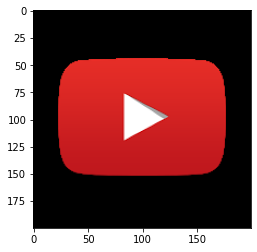

In [22]:
input_img = cv2.imread('curr_img.png')
img_rgb = cv2.cvtColor(input_img , cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [23]:
img_input = np.reshape(img_rgb , [1 , img_rgb.shape[0] , img_rgb.shape[1] , 3])

In [24]:
img_input.shape

(1, 200, 200, 3)

In [25]:
out = mymodel.predict(img_input)

In [26]:
mask = np.reshape(out , [out.shape[1] , out.shape[2]])

In [27]:
mask.shape

(200, 200)

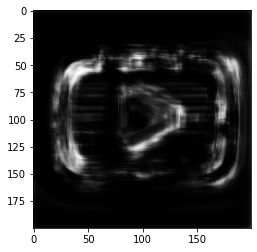

In [28]:
plt.imshow(mask , cmap = 'gray')

In [24]:
new_img = img_rgb * mask.reshape([mask.shape[0] , mask.shape[1] , 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


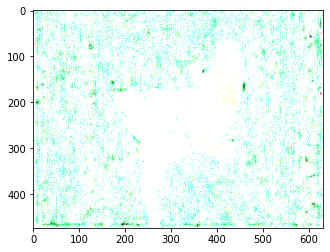

In [25]:
plt.imshow(new_img)

In [31]:
import keras
from keras.backend.common import image_data_format
import matplotlib.pyplot as plt
import cv2
import numpy as np
import urllib.request
from PIL import Image
import io
import base64

def get_mask(link):
    with urllib.request.urlopen(link) as url:
        img = url.read()
        a = np.frombuffer(img , dtype = np.uint8)
        img = cv2.imdecode(a , flags = 1)
        cv2.imwrite('curr_img.png' , img)
        model = load_pretrain_model_by_index(4 , 'pretrained_weights')
        #img_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        img_input = np.reshape(img , [1 , img.shape[0] , img.shape[1] , 3])
        out = model.predict(img_input)
        mask = np.reshape(out , [out.shape[1] , out.shape[2]])
        print(mask)
        plt.imsave('mask.png', mask, cmap='gray')

get_mask('https://www.freepnglogos.com/uploads/youtube-logo-transparent-10.png')

INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True
[[0.1751292  0.1430763  0.08522815 ... 0.09557155 0.12376913 0.15565756]
 [0.13379687 0.09855631 0.05572891 ... 0.06916845 0.0963442  0.12128705]
 [0.11614868 0.09129173 0.04921639 ... 0.05685323 0.07799897 0.09374312]
 ...
 [0.08970115 0.06347299 0.04087558 ... 0.04731134 0.06554985 0.09002769]
 [0.10259697 0.07431394 0.05133691 ... 0.06738865 0.09080711 0.12249076]
 [0.12770182 0.10252866 0.07609004 ... 0.10146555 0.12839758 0.1596891 ]]
